In [1]:
#|export
from tsai.imports import *
from tsai.models.layers import *
from torchinfo import summary

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from scipy import signal
# from tqdm.notebook import tqdm

In [1]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

NameError: name 'torch' is not defined

In [4]:
# hyper parameter
num_classes = 30
close_num = 14 # 14, 19, 24, 29
batch_size = 64
learning_rate = 0.0001
num_epochs = 200
down_ratio = 8
sequence_len = 2000 * 5 // down_ratio # default 2000Hz
overlap = int(sequence_len * 0.3)
threshold = 0.998
thresholds = [0.3, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80]
close_nums = [14, 19, 24, 29]
alpha = 0.1

In [5]:
radar_frame_list = []
scaler = MinMaxScaler((-1, 1)) # or StandardScaler

for i in range(1, num_classes + 1):
    # wave_2d = [] # input need to be 2d?
    file_path = "./data/radar_%02d.csv" % i # or ./data/radar_%02d
    radar_frame = pd.read_csv(file_path)
    wave = radar_frame.to_numpy().flatten()
    wave = signal.decimate(wave, down_ratio) # down sampling
    
    end = len(wave)
    n = 0
    n_stop = sequence_len
    wave_segments = []

    while n_stop < end:
        n_start = 0 + ((sequence_len - 1) - (overlap - 1)) * n
        n_stop = n_start + sequence_len
        tmp = []
        seg = wave[n_start:n_stop].copy()
        wave_segments.append([seg])
        n += 1
    
    radar_frame_list.append(wave_segments)

data_df = pd.DataFrame(radar_frame_list)

In [6]:
labels = []
for i in range(len(radar_frame_list)):
    for j in range(len(radar_frame_list[i])):
        if i <= close_num:
            labels.append(i)
        else:
            labels.append(close_num + 1)

labels_series = pd.Series(labels)

In [7]:
tmp = data_df.to_numpy().flatten().copy()
data_series = pd.Series(tmp).dropna() # remove None (keys are as they are)
tmp = data_series.to_numpy().flatten()

tmp_labels = labels_series.to_numpy().flatten()
# len(tmp) = 5442 (30人分のデータ)
# len(tmp[0]) = 1 (in_channelが1のため)
# len(tmp[0][0]) = 1250 (sequence_len)

for i in reversed(range(len(tmp))):
  if len(tmp[i][0]) != sequence_len:
    # print(i, len(tmp[i][0]))
    tmp = np.delete(tmp, i)
    tmp_labels = np.delete(tmp_labels, i)

data_series = pd.Series(tmp)
labels_series = pd.Series(tmp_labels)
labels_tensor = torch.tensor(labels_series)
data_series.shape, labels_tensor, labels_tensor.shape

((5413,), tensor([ 0,  0,  0,  ..., 15, 15, 15]), torch.Size([5413]))

In [9]:
class InceptionModule(Module):
    def __init__(self, ni, nf, ks=40, bottleneck=True):
        ks = [ks // (2**i) for i in range(3)]
        ks = [k if k % 2 != 0 else k - 1 for k in ks]  # ensure odd ks
        bottleneck = bottleneck if ni > 1 else False
        self.bottleneck = Conv1d(ni, nf, 1, bias=False) if bottleneck else noop
        self.convs = nn.ModuleList([Conv1d(nf if bottleneck else ni, nf, k, bias=False) for k in ks])
        self.maxconvpool = nn.Sequential(*[nn.MaxPool1d(3, stride=1, padding=1), Conv1d(ni, nf, 1, bias=False)])
        self.concat = Concat()
        self.bn = BN1d(nf * 4)
        self.act = nn.ReLU()

    def forward(self, x):
        input_tensor = x
        x = self.bottleneck(input_tensor)
        x = self.concat([l(x) for l in self.convs] + [self.maxconvpool(input_tensor)])
        return self.act(self.bn(x))


@delegates(InceptionModule.__init__)
class InceptionBlock(Module):
    def __init__(self, ni, nf=32, residual=True, depth=6, **kwargs):
        self.residual, self.depth = residual, depth
        self.inception, self.shortcut = nn.ModuleList(), nn.ModuleList()
        for d in range(depth):
            self.inception.append(InceptionModule(ni if d == 0 else nf * 4, nf, **kwargs))
            if self.residual and d % 3 == 2: 
                n_in, n_out = ni if d == 2 else nf * 4, nf * 4
                self.shortcut.append(BN1d(n_in) if n_in == n_out else ConvBlock(n_in, n_out, 1, act=None))
        self.add = Add()
        self.act = nn.ReLU()
        
    def forward(self, x):
        res = x
        for d, l in enumerate(range(self.depth)):
            x = self.inception[d](x)
            if self.residual and d % 3 == 2: res = x = self.act(self.add(x, self.shortcut[d//3](res)))
        return x

    
@delegates(InceptionModule.__init__)
class InceptionTime(Module):
    def __init__(self, c_in, c_out, seq_len=None, nf=32, nb_filters=None, **kwargs):
        nf = ifnone(nf, nb_filters) # for compatibility
        self.inceptionblock = InceptionBlock(c_in, nf, **kwargs) # c_in is input channel num of conv1d
        self.gap = GAP1d(1)
        self.fc = nn.Linear(nf * 4, c_out) # c_out is 1d output size 
        self.fc_tsne = nn.Linear(nf * 4, 2)
        self.two_vecs_train = []
        self.two_vecs_test = []

    def forward(self, x):
        x = self.inceptionblock(x)
        x = self.gap(x)
        two_dimensional_vec = self.fc_tsne(x)
        if self.training:
            self.two_vecs_train.append(two_dimensional_vec)
        else:
            self.two_vecs_test.append(two_dimensional_vec)
        x = self.fc(x)
        return x

In [ ]:
def save_feature_mapping(self, features, labels):
    if self.traing: # Train mode
        two_vecs = model.two_vecs[-1].cpu().detach().numpy().copy()
        x, y = zip(*two_vecs)
        fig = plt.scatter(x, y)
        plt.savefig(fig)
    else: # Eval mode
        two_vecs = model.two_vecs[-1].cpu().detach().numpy().copy()
        x, y = zip(*two_vecs)
        fig = plt.scatter(x, y)
        plt.savefig(fig)

In [78]:
# from tsai.models.utils import count_parameters

In [10]:
class MyDataset(Dataset):
    def __init__(self, dataset, labels, root_dir, transform=None) -> None:
        # super().__init__()
        self.radar_heartbeat = dataset
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
          idx = idx.tolist()
        
        onehot_label = torch.eye(num_classes)[self.labels[idx] - 1] # one hot encodingは不要らしい　精度悪い場合試す必要あり
        # one_hot = torch.nn.functional.one_hot(self.labels, num_classes=num_classes)
        return torch.tensor(self.radar_heartbeat[idx]), self.labels[idx] # labels is already tensor (converted in preparation phase)
        # return torch.tensor(self.radar_heartbeat[idx]), onehot_label

    def __len__(self):
        return len(self.radar_heartbeat)


dataset = MyDataset(data_series, labels_tensor, "./data/", transform=transforms.ToTensor())

In [ ]:
dataset[0][1], dataset[4473][1], dataset[4474][1], dataset[len(dataset)-1][1]

In [ ]:
dataset[3570][1], dataset[3571][1]

In [ ]:
dataset[2691][1], dataset[2692][1]

Additional processing for Open Set

e.g.
train 0~24

test 0~30

concat

In [83]:
# indices1 = np.arange(4473)
# dataset1 = torch.utils.data.Subset(dataset, indices1) # 0-24
# indices2 = np.arange(4474, len(dataset))
# dataset2 = torch.utils.data.Subset(dataset, indices2) # 25-30
# Unknown_label = close_num + 1

In [84]:
# indices1 = np.arange(3570)
# dataset1 = torch.utils.data.Subset(dataset, indices1) # 0-19
# indices2 = np.arange(3571, len(dataset))
# dataset2 = torch.utils.data.Subset(dataset, indices2) # 20-30
# Unknown_label = close_num + 1

In [14]:
indices1 = np.arange(2691)
dataset1 = torch.utils.data.Subset(dataset, indices1) # 0-14
indices2 = np.arange(2692, len(dataset))
dataset2 = torch.utils.data.Subset(dataset, indices2) # 15-29
Unknown_label = close_num + 1

In [15]:
train_size1 = int(0.80 * len(dataset1))
test_size1 = len(dataset1) - train_size1

train_size2 = int(0.80 * len(dataset2))
test_size2 = len(dataset2) - train_size2

open_train_set, test_set1 = torch.utils.data.random_split(dataset1, [train_size1, test_size1])
train_set2, test_set2 = torch.utils.data.random_split(dataset2, [train_size2, test_size2])

indices = np.arange(len(test_set2))
test_set2 = torch.utils.data.Subset(test_set2, indices[:])

train : test = 8 : 2 → 3 : 1で分ける

In [16]:
open_test_set = torch.utils.data.ConcatDataset([test_set1, test_set2])
len(open_train_set), len(open_test_set)

(2152, 1084)

In [17]:
train_loader = DataLoader(dataset=open_train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=open_test_set, batch_size=batch_size, shuffle=False) # テストでシャッフルしても同じ

## Triple Joint Loss

In [22]:
from torch import log
softmax = nn.Softmax()

def softmax_loss(outputs, labels):
    loss = 0
    batch_size = len(labels)
    logsoftmax_out = log(softmax(outputs))
    for idx in range(batch_size):
        loss += 1.0 - logsoftmax_out[idx][labels[idx]]
    
    return loss / batch_size


from center_loss import CenterLoss
center_loss = CenterLoss(num_classes=close_num + 1, feat_dim=close_num + 1, use_gpu=True) # 入出力が同じだと一見変な感じがするが，交差エントロピーと違ってcenterlossを使うと最初から決めていれば，モデルの出力サイズを必ずしもクラス数に一致させる必要がないからfeat_dimを任意に設定できる．
optimizer_centloss = torch.optim.SGD(center_loss.parameters(), lr=0.05)


class AngularPenaltySMLoss(nn.Module):

    def __init__(self, in_features, out_features, loss_type='cosface', eps=1e-7, s=None, m=None):
        '''
        Angular Penalty Softmax Loss
        Three 'loss_types' available: ['arcface', 'sphereface', 'cosface']
        These losses are described in the following papers: 
        
        ArcFace: https://arxiv.org/abs/1801.07698
        SphereFace: https://arxiv.org/abs/1704.08063
        CosFace/Ad Margin: https://arxiv.org/abs/1801.05599
        '''
        super(AngularPenaltySMLoss, self).__init__()
        loss_type = loss_type.lower()
        assert loss_type in  ['arcface', 'sphereface', 'cosface']
        if loss_type == 'arcface':
            self.s = 64.0 if not s else s
            self.m = 0.5 if not m else m
        if loss_type == 'sphereface':
            self.s = 64.0 if not s else s
            self.m = 1.35 if not m else m
        if loss_type == 'cosface':
            self.s = 32.0 if not s else s
            self.m = 0.2 if not m else m
        self.loss_type = loss_type
        self.in_features = in_features
        self.out_features = out_features
        self.fc = nn.Linear(in_features, out_features, bias=False)
        self.fc.to(device)
        self.eps = eps

    def forward(self, x, labels):
        '''
        input shape (N, in_features)
        '''
        assert len(x) == len(labels)
        assert torch.min(labels) >= 0
        assert torch.max(labels) < self.out_features
        
        for W in self.fc.parameters():
            W = F.normalize(W, p=2, dim=1)

        x = F.normalize(x, p=2, dim=1)
        # logを引き算に変えて計算
        wf = self.fc(x)
        if self.loss_type == 'cosface':
            numerator = self.s * (torch.diagonal(wf.transpose(0, 1)[labels]) - self.m)
        if self.loss_type == 'arcface':
            numerator = self.s * torch.cos(torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)) + self.m)
        if self.loss_type == 'sphereface':
            numerator = self.s * torch.cos(self.m * torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)))

        excl = torch.cat([torch.cat((wf[i, :y], wf[i, y+1:])).unsqueeze(0) for i, y in enumerate(labels)], dim=0)
        denominator = torch.exp(numerator) + torch.sum(torch.exp(self.s * excl), dim=1)
        L = numerator - torch.log(denominator)
        return -torch.mean(L)

cos_loss = AngularPenaltySMLoss(close_num + 1, close_num + 1, loss_type="cosface") # center_lossと同じ理由でin_featuresはクラス数でよい．


def triple_joint_loss(output, label, alpha):
    # alpha: hyper parameter
    output_only_truth = []
    for idx, x in enumerate(output):
        x = x[labels[idx]]
        x = torch.tensor(x).to(device)
        output_only_truth.append([x])
    output_only_truth = torch.tensor(output_only_truth)
    output_only_truth = output_only_truth.float()
    output_only_truth = output_only_truth.to(device)
    # print(output.is_cuda, output_only_truth.is_cuda, label.is_cuda)

    return softmax_loss(output, label) + alpha * center_loss(output, label)
    # return softmax_loss(output, label) + alpha * center_loss(output, label) + cos_loss(output, label)
    # return cos_loss(output_only_truth, label)

In [23]:
model = InceptionTime(1, close_num + 1) # 0-?+Unknownを出力
model = model.to(device)
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
model.train()
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
  for i, (signals, labels) in enumerate(train_loader):
    signals = torch.tensor(signals)
    signals = signals.float()
    signals = signals.to(device)
    labels = labels.to(device)

    # print(signals.size())
    outputs = model(signals)
    outputs = outputs.to(device)
    # print(outputs)
    loss = triple_joint_loss(outputs, labels, alpha) # will check the shapes of outputs and labels

    optimizer.zero_grad()
    optimizer_centloss.zero_grad()
    loss.backward()
    for param in center_loss.parameters():
      param.grad.data *= (1./alpha) # 98.98%を出したときはこれを書いていなかった→追加しても問題なし．
    optimizer.step()
    optimizer_centloss.step()
    if (i + 1) % 12 == 0:
      print(f'Epoch [{epoch+1}/`{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

/tmp/ipykernel_26931/2531571306.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_26931/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)


Epoch [1/`200], Step [12/34], Loss: 4.8264
Epoch [1/`200], Step [24/34], Loss: 4.4756
Epoch [2/`200], Step [12/34], Loss: 4.1638
Epoch [2/`200], Step [24/34], Loss: 3.9546
Epoch [3/`200], Step [12/34], Loss: 3.6275
Epoch [3/`200], Step [24/34], Loss: 3.4951
Epoch [4/`200], Step [12/34], Loss: 3.3788
Epoch [4/`200], Step [24/34], Loss: 3.2163
Epoch [5/`200], Step [12/34], Loss: 3.1596
Epoch [5/`200], Step [24/34], Loss: 3.0284
Epoch [6/`200], Step [12/34], Loss: 3.0199
Epoch [6/`200], Step [24/34], Loss: 2.7694
Epoch [7/`200], Step [12/34], Loss: 2.7342
Epoch [7/`200], Step [24/34], Loss: 2.8257
Epoch [8/`200], Step [12/34], Loss: 2.8076
Epoch [8/`200], Step [24/34], Loss: 2.6585
Epoch [9/`200], Step [12/34], Loss: 2.5997
Epoch [9/`200], Step [24/34], Loss: 2.5329
Epoch [10/`200], Step [12/34], Loss: 2.5778
Epoch [10/`200], Step [24/34], Loss: 2.3754
Epoch [11/`200], Step [12/34], Loss: 2.3251
Epoch [11/`200], Step [24/34], Loss: 2.2237
Epoch [12/`200], Step [12/34], Loss: 2.3873
Epoch 

labelは0-24までだから，学習はいじらなくて大丈夫

testはOpen setの場合，0~24とUnknown label(25)になるから，labelは作り直し

25も出力するようなネットワークにしなきゃだめ

In [25]:
threshold = 0.65

In [ ]:
# For Confusion Matrix
predicted_lists = np.zeros(0, dtype=np.int64)
one_hot_labels_list = np.zeros(0, dtype=np.int64)
model.eval()

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  softmax = nn.Softmax()
  for i, (signals, one_hot_labels) in enumerate(test_loader):
    signals = torch.tensor(signals)
    signals = signals.float()
    signals = signals.to(device)
    one_hot_labels = one_hot_labels.to(device)
    # print(len(one_hot_labels))
    outputs = model(signals)
    for j, out in enumerate(outputs):
      outputs[j] = softmax(out)

    _, predicted = torch.max(outputs.data, 1) # predicted per batch size
    
    
    for idx in range(len(_)):
      if _[idx] < threshold:
        predicted[idx] = Unknown_label # 15, 20, 25
    print(_, predicted, one_hot_labels)

    n_samples += one_hot_labels.size(0) # add batch_size
    n_correct += (predicted == one_hot_labels).sum().item()
    
    predicted_cp = predicted.to('cpu').detach().numpy().copy()
    one_hot_labels_cp = one_hot_labels.to('cpu').detach().numpy().copy()
    predicted_lists = np.concatenate([predicted_lists, predicted_cp])
    one_hot_labels_list = np.concatenate([one_hot_labels_list, one_hot_labels_cp])
    
    acc = 100.0 * n_correct / n_samples
    print(f'{n_correct} / {n_samples} = Acc: {acc} %')

In [ ]:
predicted_cp, one_hot_labels_cp

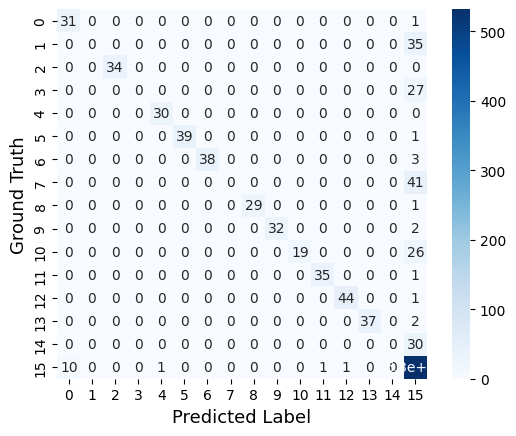

In [271]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(one_hot_labels_list, predicted_lists)
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.xlabel("Predicted Label", fontsize=13)
plt.ylabel("Ground Truth", fontsize=13)
fig_name = "sklearn_confusion_matrix_{}_{}.png".format(Unknown_label, threshold)
# plt.savefig("./figure/" + fig_name)

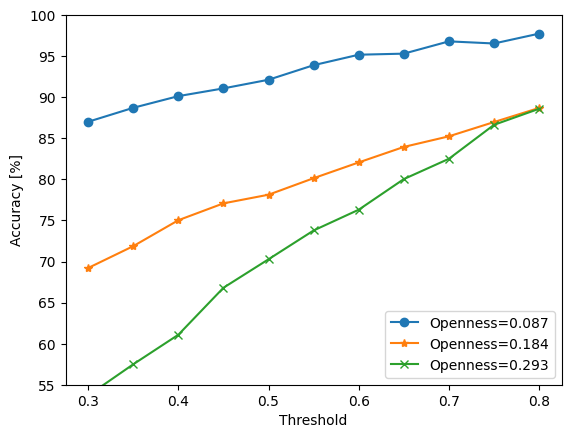

In [273]:
a = np.array([55.35055350553505, 61.99261992619926, 64.11439114391143, 70.75645756457564, 74.6309963099631, 73.5239852398524, 77.58302583025831, 84.5940959409594, 81.91881918819188, 90.59040590405904, 88.46863468634686])
b = np.array([55.71955719557196, 57.564575645756456, 61.62361623616236, 70.9409594095941, 71.58671586715867, 76.56826568265683, 75.27675276752767, 76.19926199261992, 81.2730627306273, 84.96309963099631, 88.00738007380073])
c = np.array([51.93726937269373, 54.7970479704797, 58.025830258302584, 62.08487084870849, 66.32841328413284, 71.03321033210332, 74.72324723247233, 78.50553505535055, 81.91881918819188, 84.77859778597787, 87.82287822878229])
d = np.array([52.859778597785976, 56.91881918819188, 61.254612546125465, 66.14391143911439, 70.84870848708488, 75.46125461254613, 78.87453874538745, 82.10332103321034, 85.05535055350553, 87.63837638376384, 90.59040590405904])
e = np.array([52.5830258302583, 56.18081180811808, 60.42435424354244, 64.11439114391143, 67.98892988929889, 72.32472324723247, 75.09225092250922, 78.78228782287823, 82.380073800738, 85.23985239852398, 88.09963099630997])
ave14 = np.mean([a, b, c, d, e], axis=0)

a1 = np.array([68.88273314866113, 73.40720221606648, 77.65466297322253, 78.67036011080333, 78.76269621421976, 84.57987072945522, 83.28716528162512, 87.44228993536473, 85.96491228070175, 88.9196675900277, 88.73499538319483])
b1 = np.array([69.3444136657433, 71.46814404432133, 76.08494921514313, 78.02400738688827, 78.30101569713759, 76.5466297322253, 83.10249307479225, 83.28716528162512, 87.07294552169898, 87.6269621421976, 90.2123730378578])
c1 = np.array([69.43674976915975, 71.83748845798708, 74.33056325023084, 76.36195752539243, 78.20867959372114, 81.4404432132964, 83.10249307479225, 85.68790397045245, 86.79593721144968, 89.10433979686057, 91.68975069252078])
d1 = np.array([68.69806094182826, 70.3601108033241, 72.11449676823638, 74.42289935364728, 75.53093259464451, 76.73130193905817, 78.02400738688827, 78.76269621421976, 80.33240997229917, 81.80978762696215, 84.11819021237304])
e1 = np.array([69.71375807940905, 72.29916897506925, 74.9769159741459, 77.93167128347184, 79.87072945521699, 81.4404432132964, 82.82548476454294, 84.57987072945522, 86.0572483841182, 87.44228993536473, 88.73499538319483])

ave19 = np.mean([a1, b1, c1, d1, e1], axis=0)

a2 = np.array([88.36565096952909, 91.87442289935365, 91.59741458910435, 93.62880886426593, 92.89012003693445, 93.90581717451524, 96.67590027700831, 95.10618651892891, 98.33795013850416, 95.38319482917821, 97.78393351800554])
b2 = np.array([87.90397045244691, 88.82733148661127, 91.59741458910435, 88.6426592797784, 91.2280701754386, 94.73684210526316, 94.73684210526316, 93.72114496768236, 95.93721144967682, 95.66020313942752, 97.04524469067405])
c2 = np.array([85.87257617728532, 87.53462603878117, 89.47368421052632, 91.59741458910435, 92.05909510618652, 93.25946445060019, 93.8134810710988, 95.01385041551247, 95.8448753462604, 96.67590027700831, 97.96860572483841])
d2 = np.array([86.88827331486611, 88.18097876269621, 89.38134810710989, 90.39704524469067, 91.5050784856879, 92.89012003693445, 94.45983379501385, 95.29085872576178, 96.02954755309327, 96.86057248384118, 97.4145891043398])
e2 = np.array([86.0572483841182, 87.16528162511543, 88.6426592797784, 91.13573407202216, 92.98245614035088, 94.73684210526316, 96.21421975992614, 97.4145891043398, 97.87626962142198, 98.15327793167128, 98.52262234533703])

ave24 = np.mean([a2, b2, c2, d2, e2], axis=0)

x = np.linspace(0.30, 0.80, 11)
y1 = ave14
y2 = ave19
y3 = ave24
y0 = [99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08]
plt.ylim(55, 100)
plt.xlabel("Threshold")
plt.ylabel("Accuracy [%]")
# plt.plot(x, y0, label="Openness=0, (threshold=0)")
plt.plot(x, y3, marker="o", label="Openness=0.087")
plt.plot(x, y2, marker="*", label="Openness=0.184")
plt.plot(x, y1, marker="x", label="Openness=0.293")
plt.legend()

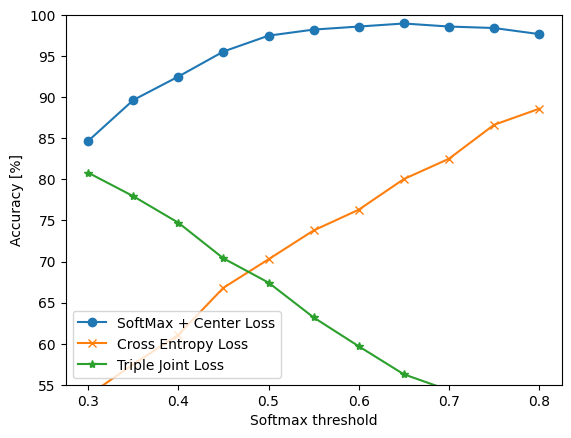

In [280]:
x = np.linspace(0.30, 0.80, 11)
y1 = ave14

y_soft_center = [84.68, 89.66, 92.52, 95.57, 97.50, 98.24, 98.61,  98.98, 98.61, 98.43, 97.69]
y_triple = [80.81, 77.95,  74.72, 70.38, 67.43, 63.19, 59.68, 56.27, 54.33, 52.21, 50.92]
plt.ylim(55, 100)
plt.xlabel("Softmax threshold")
plt.ylabel("Accuracy [%]")
plt.plot(x, y_soft_center, marker="o", label="SoftMax + Center Loss")
plt.plot(x, y1, marker="x", label="Cross Entropy Loss")
plt.plot(x, y_triple, marker="*", label="Triple Joint Loss")

plt.legend()


In [52]:
len(model.two_vecs), model.two_vecs[0]

(6817,
 TensorBase([[ 2.6110e-01,  1.2138e-01],
             [-5.4911e-04,  1.5209e-02],
             [-1.7548e-01,  6.7983e-02],
             [ 3.9424e-01,  5.5364e-02],
             [-9.2376e-02, -3.0268e-02],
             [-9.5030e-02, -7.7480e-03],
             [-1.0136e-01,  9.1698e-03],
             [-1.6300e-01, -7.4902e-03],
             [ 2.1907e-01,  6.7580e-02],
             [ 2.0019e-02,  4.6416e-02],
             [ 3.2682e-01,  8.4382e-02],
             [ 2.7581e-01,  9.7601e-02],
             [ 5.4145e-02,  1.8181e-02],
             [ 3.8023e-04, -3.2912e-03],
             [-1.5671e-01,  1.3993e-02],
             [-1.0014e-01,  1.7021e-02],
             [-3.3500e-03,  2.1658e-02],
             [-2.1601e-01,  2.3388e-02],
             [-3.0626e-01,  7.4776e-03],
             [ 1.9377e-01,  3.4453e-02],
             [-1.6546e-01, -4.0053e-02],
             [-5.5705e-02,  2.4933e-02],
             [ 1.1211e-01,  7.8908e-02],
             [-2.0695e-02,  5.5531e-02],
         

model.two_vecsは 6817 * 64(batch_size) * 2になっちゃってる

正規化された値？訓練かテストのときの値なのか，softmaxを通っているのかはっきりさせる必要あり

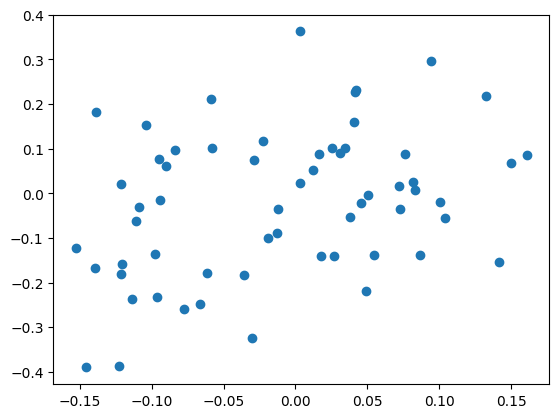

In [63]:
two_vecs = model.two_vecs[-1].cpu().detach().numpy().copy()
x, y = zip(*two_vecs)
plt.scatter(x, y)